# Nichtlineare Systeme und Maschinelles Lernen

In [367]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sklearn.svm as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
warnings.filterwarnings('ignore')
%matplotlib inline

### Definiere ein nichtlineares System: Tank mit Zu- und Ablauf

$h(t) = A_{zu} /A \int{u(t) dt} - A_{abfluss}/A \sqrt{2 g} \int{\sqrt{h(t)} dt}$ 

Überführung in eine Zustandsdarstellung

$ \dot{h}(t) = 1/A u(t) - A_{abfluss}/A \sqrt{2 g} \sqrt{h(t)}$

Zeitdiskretisierung 

$ \dot{h}(t) \approx \frac{h(k+1) - h(k) }{T} $

Zuerst wird das System im Ausgangszustand simuliert

In [368]:
# Anzahl der Zeitschritte für die Simulation des Tanks
n_iter = 10000
T = 0.01
noise_level = 0.01

x = np.zeros(n_iter)
u = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
u_white = np.random.normal(0.2, 0.4, n_iter)

# TP-Filter 1. Ordnung
filter_T = 0.05
for k in range(n_iter):
    u[k] = (1-filter_T)*u[k-1] + filter_T*u_white[k]

# Parametrierung und Simulation des Zustandsraummodells
# Parameter: Verhältnisse der Querschnitte von Behälter, Zulauf und Ablauf
A = 10
Aab = 0.5
Azu = 0.5
for k in range(n_iter-1):
    x[k+1] = Azu/A * T * u [k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200 # Die Skalierung wird nur vorgenommen, um die Plots von u und h einfacher übereinander darstellen zu könnnen

# Weisses Rauschen als Messrauschen
output_noise = np.random.normal(0.0, noise_level, n_iter)

h_normal = h + output_noise

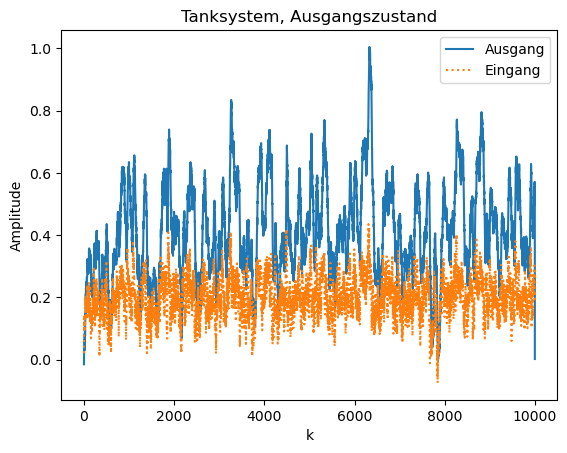

In [369]:
plt.figure()
plt.plot(h_normal, label= 'Ausgang')
plt.plot(u,linestyle=':', label='Eingang')
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()
plt.title("Tanksystem, Ausgangszustand")
plt.show()

Schätzung eines einfachen ARX(1,1) Modells 

In [370]:
# Regressor
phi = np.zeros((n_iter, 2))
for k in range(n_iter):
    phi[k, :] = [u[k-1], h_normal[k-1]]

ARX, residuals, rank, s = np.linalg.lstsq(phi,h_normal,-1)

Das Modell ist linear und daher nicht besonders gut


In [371]:
h_dach_arx = np.zeros_like(x)
for k in range(n_iter-1):
    h_dach_arx[k+1] = np.dot(ARX, [u[k], h_dach_arx[k]])

Text(0.5, 1.0, 'Tanksystem, Ausgangszustand')

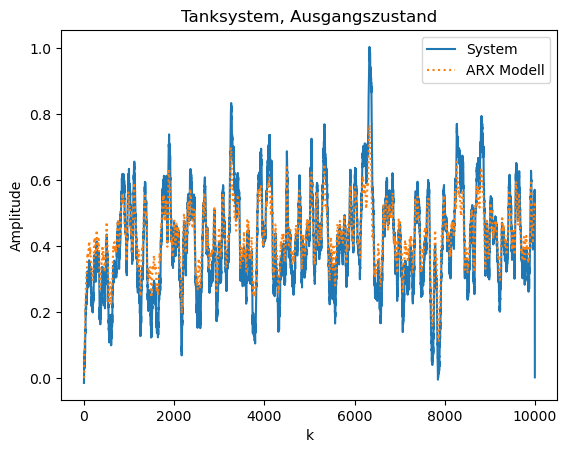

In [372]:
plt.figure()
plt.plot(h_normal, label= 'System')
plt.plot(h_dach_arx,linestyle=':', label='ARX Modell')
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()
plt.title("Tanksystem, Ausgangszustand")

## Simulation verschiedener Fehler

### Zustände des Tanksystems 
1. Nominalzustand (wie oben simuliert)
2. Zulaufventil hängt fest: unabhängig vom Eingangssignal wird ein fester Wert für den Zulauf gesetzt
4. Ablauf teilweise verstopft: Querschnitt des Ablaufs wird temporär verringert
5. Füllstandssensor mit elektrischem Fehler. 50Hz Signal wird eingestreut: Überlagerung des Ausgangssignals mit einem periodischen Störsignal

Modellierung durch einen Markov-Prozess:

https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/

Der Markov-Prozess stellt sein System durch verschiedene Zustände dar, die über der Zeit mit definierten Wahrscheinlichkeiten wechseln.

In [373]:
from scipy.stats import multinomial
from typing import List

def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [374]:
# Wahrscheinlichkeitsverteilung des Ausgangszustands
p_init = np.array([1.0, 0.0])
# Wahrscheinlichkeiten für den Zustandsübergang
p_transition = np.array([[0.99, 0.01],[0.02, 0.98]])
# Berechnung einer Markov-Sequenz 
states = np.array(markov_sequence(p_init, p_transition, sequence_length=n_iter))

Text(0.5, 1.0, 'Fehlerzustände des Systems')

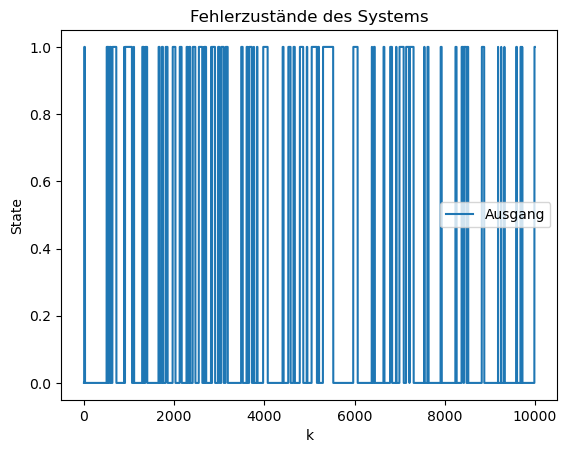

In [375]:
plt.figure()
plt.plot(states, label= 'Ausgang')
#plt.plot(u,linestyle=':', label='Eingang')
plt.xlabel('k')
plt.ylabel('State')
plt.legend()
plt.title("Fehlerzustände des Systems")

Modifikation des Tankmodells zur Abbildung der Fehlerzustände



In [376]:
# Anzahl der Zeitschritte für die Simulation des Tanks
x = np.zeros(n_iter)
u_in = np.zeros_like(x)
u = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
# u_white = np.random.normal(0.2, 0.4, n_iter) kein neues Eingangssignal generieren

# TP-Filter 1. Ordnung
filter_T = 0.05
for k in range(n_iter):
    u[k] = (1-filter_T)*u[k-1] + filter_T*u_white[k]

    if states[k] == 2:
        # Ventilantrieb hängt: Eingangswerte verändern sich nicht mehr
        u_in[k] = u_in[k-1] 
    else:
        u_in[k] = u[k]

# Parametrierung und Simulation des Zustandsraummodells
# Parameter: Verhältnisse der Querschnitte von Behälter, Zulauf und Ablauf
A = 10
Aab = 0.5
Azu = 0.5
for k in range(n_iter-1):
    if states[k] == 0:
        Aab = 0.5
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    elif states[k] == 1:
        # Ablauf verstopft -> Ablaufquerschnitt verkleinert
        Aab = 0
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
  
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200 # Die Skalierung wird nur vorgenommen, um die Plots von u und h einfacher übereinander darstellen zu könnnen

# Weisses Rauschen als Messrauschen
output_noise = np.random.normal(0.0, noise_level, n_iter)

h = h + output_noise


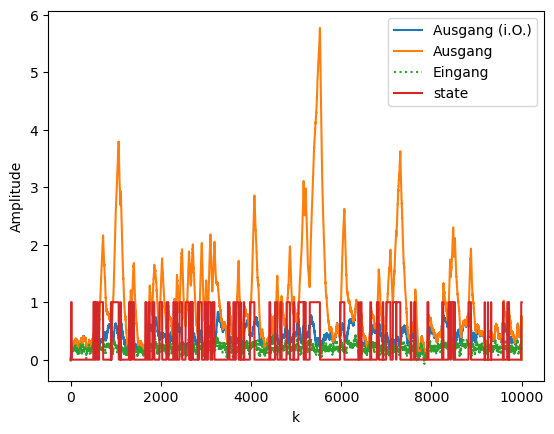

In [377]:
plt.figure()
plt.plot(h_normal, label="Ausgang (i.O.)")
plt.plot(h, label= 'Ausgang')
plt.plot(u, linestyle=':', label='Eingang')
plt.plot(states, label = "state")
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()

In [378]:
# Berechnung des Residuums der ARX Schätzung als Eingang für die Fehlerdetektion 
h_dach_arx = np.zeros_like(x)
for k in range(n_iter-1):
    h_dach_arx[k+1] = np.dot(ARX, [u_in[k], h_dach_arx[k]])

residuum = h_dach_arx - h

In [379]:
# Option 2: Samples des Residuums als Features für das Training des Klassifikators
l = 10
phi = np.zeros((n_iter, l))
for k in range(n_iter-l):
    phi[k, :] = residuum[k:k+l]

In [380]:
# Aufteilen in Trainings- und Testdaten

In [381]:
X_train, X_test, y_train, y_test = train_test_split(phi, states, random_state=4)

In [382]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 5), random_state=42)

In [383]:
clf = clf.fit(X_train, y_train)

In [384]:
# Prädiktion mit den Ausgangswerten aus den Trainingsdaten, die im Regressor gesammelt wurden
h_predict = clf.predict(phi)

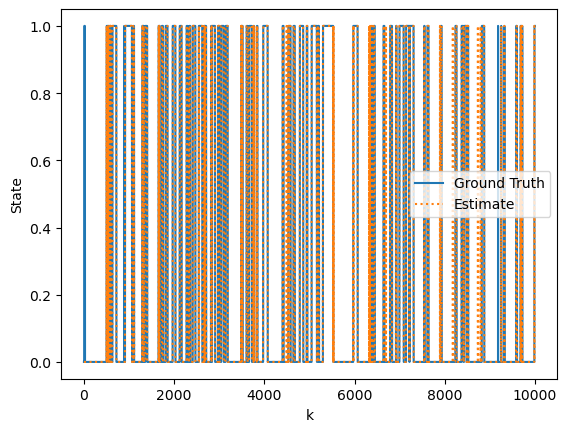

In [385]:
plt.figure()
plt.plot(states, label= 'Ground Truth')
plt.plot(h_predict,linestyle=':', label='Estimate')
plt.xlabel('k')
plt.ylabel('State')
plt.legend()

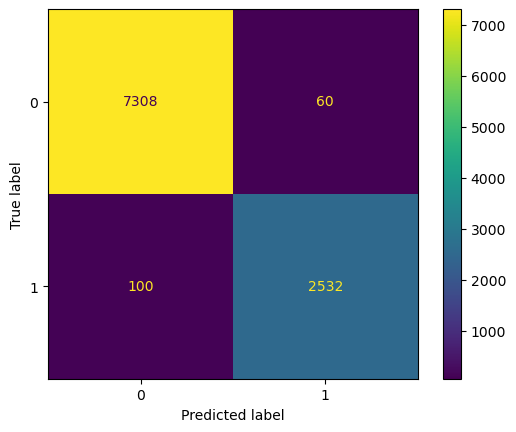

In [386]:
cm = confusion_matrix(states, h_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

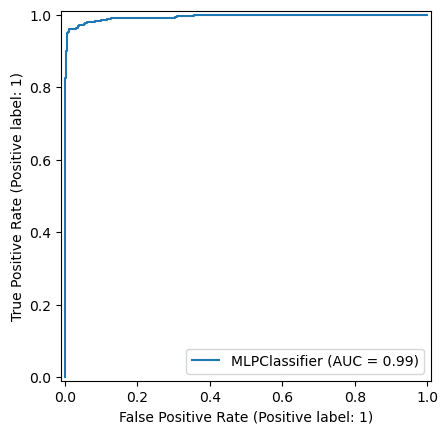

In [387]:
clf_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

### Testen des trainierten Modells mit einem neuem Datensatz 

In [388]:
n_iter = 1000

In [389]:
# Wahrscheinlichkeitsverteilung des Ausgangszustands
p_init = np.array([1.0, 0.0])
# Wahrscheinlichkeiten für den Zustandsübergang
p_transition = np.array([[0.99, 0.01],[0.01, 0.99]])
# Berechnung einer Markov-Sequenz 
states = np.array(markov_sequence(p_init, p_transition, sequence_length=n_iter))

In [390]:
# Anzahl der Zeitschritte für die Simulation des Tanks
x = np.zeros(n_iter)
u_in = np.zeros_like(x)
u = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
#u_white = np.random.normal(0.2, 0.4, n_iter)

# TP-Filter 1. Ordnung
filter_T = 0.05
for k in range(n_iter):
    u[k] = (1-filter_T)*u[k-1] + filter_T*u_white[k]

    if states[k] == 2:
        u_in[k] = u_in[k-1]
    else:    
        u_in[k] = u[k]
        # Ventilantrieb hängt: Werte bleiben 
         

# Parametrierung und Simulation des Zustandsraummodells
# Parameter: Verhältnisse der Querschnitte von Behälter, Zulauf und Ablauf
A = 10
Aab = 0.5
Azu = 0.5
for k in range(n_iter-1):
    if states[k] == 0:
        Aab = 0.5
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    elif states[k] == 1:
        # Ablauf verstopft
        Aab = 0.01
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
  
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200 # Die Skalierung wird nur vorgenommen, um die Plots von u und h einfacher übereinander darstellen zu könnnen

output_noise = np.random.normal(0.0, noise_level, n_iter)

h = h + output_noise


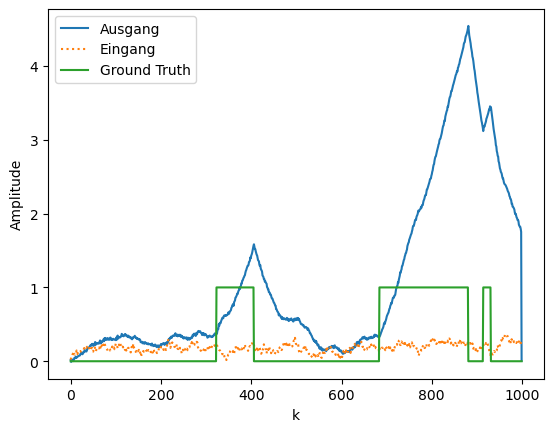

In [391]:
plt.figure()
plt.plot(h, label= 'Ausgang')
plt.plot(u, linestyle=':', label='Eingang')
plt.plot(states, label= 'Ground Truth')
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()

In [392]:
# Alternativer Ansatz - Residuum als Features
h_dach_arx = np.zeros_like(x)
for k in range(n_iter-1):
    h_dach_arx[k+1] = np.dot(ARX, [u[k], h_dach_arx[k]])

residuum = h_dach_arx - h
l = 10
phi = np.zeros((n_iter, l))
for k in range(n_iter-l):
    phi[k, :] = residuum[k:k+l]

In [393]:
# Prädiktion mit den Ausgangswerten aus den Trainingsdaten, die im Regressor gesammelt wurden
h_predict = clf.predict(phi)

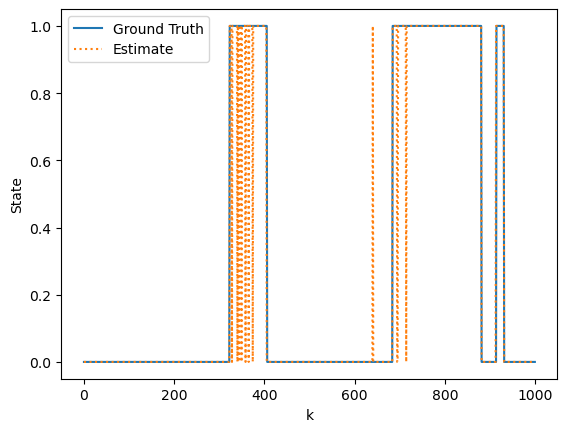

In [394]:
plt.figure()
plt.plot(states, label= 'Ground Truth')
plt.plot(h_predict,linestyle=':', label='Estimate')
plt.xlabel('k')
plt.ylabel('State')
plt.legend()

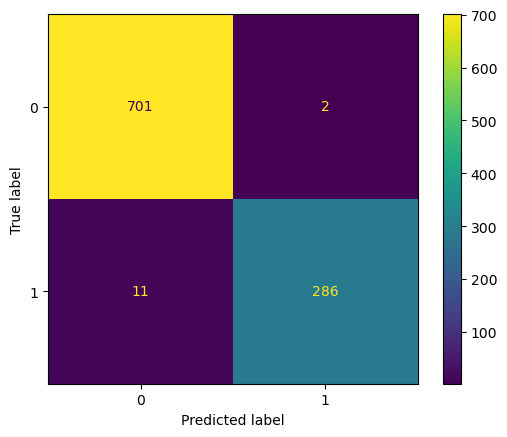

In [395]:
cm = confusion_matrix(states, h_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [396]:
clf

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3, 5), random_state=42,
              solver='lbfgs')